In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch2/nkudryas/BAND-torch/notebooks/').parent / p)
)

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "6"

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import h5py 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [16]:
dataset_name = f'chewie_10_05'
model_str='kl1_gauss'

bin_size_ms = 10

In [17]:
models_folder = f"/disk/scratch/nkudryas/BAND-torch/runs/pbt-band-paper-slurm/{dataset_name}"

fac_dim, co_dim = 100,4
bw = 0.1
encod_seq_len = 101
encod_data_dim = 207
seed = 2
model_name = f"band_both_{fac_dim}f_{model_str}_bd"
model_dest = f"{models_folder}/{model_name}"

model_dest


'/disk/scratch/nkudryas/BAND-torch/runs/pbt-band-paper-slurm/chewie_10_05/band_both_100f_kl1_gauss_bd'

In [18]:
path = f'../../datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_go.h5'
data = h5py.File(path, 'r')
data.keys()

true_target_direction = data['valid_target_direction']

In [19]:
# Get the paths to all data files
both_rates = []
last_epoch = None
for output_file in ['lfads_output_go.h5','lfads_ablated_output_go.h5']:
    data_path = os.path.join(model_dest,'best_model',output_file)
    # Data is binned at 10 ms
    with h5py.File(data_path) as f:
        print(f.keys())
        # Merge train and valid data for factors and rates
        rates = np.concatenate([f['train_output_params'][:],f['valid_output_params'][:]],axis=0)
        epoch = np.concatenate([f['train_epoch'][:],f['valid_epoch'][:]],axis=0)
        if last_epoch is None:
            last_epoch = epoch
        else:
            assert np.array_equal(last_epoch, epoch), "Epochs do not match across models"
    both_rates.append(rates)

both_rates = np.array(both_rates)

<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_pa

In [21]:
T = 50
log_rate_diff = np.log(both_rates[0]+1e-10) - np.log(both_rates[1]+1e-10)
per_neuron_rate_diff = log_rate_diff[:,T:].mean(0).mean(0)
mean = per_neuron_rate_diff.mean()
std = per_neuron_rate_diff.std()


# detect outliers
outliers = (np.abs(log_rate_diff[epoch==1,T:].mean(0).mean(0) - mean) >  2* std) & \
            (np.abs(log_rate_diff[epoch==0,T:].mean(0).mean(0) - mean) <= 2 * std)
print(f"Number of outliers: {np.sum(outliers)}")
print(np.where(outliers)[0])

mask_BL = (np.abs(log_rate_diff[epoch==0,T:].mean(0).mean(0) - mean) <= 2 * std)
idxs_masked = np.where(mask_BL)[0]
top_5 = idxs_masked[np.argsort(np.abs(log_rate_diff[epoch==1,T:].mean(0).mean(0) - mean)[mask_BL])[-5:]]
print(f"Top 5 neurons: {top_5}")
print(np.sort(top_5))

Number of outliers: 11
[ 12  22  43 117 139 154 163 172 182 214 229]
Top 5 neurons: [139 163 214 182  43]
[ 43 139 163 182 214]


In [25]:
both_rates[1].mean(), both_rates[1][...,163].mean()

(0.09174285, 0.0673355)

In [8]:
resampled_log_rate = np.zeros((100, both_rates.shape[-1]))
for i in range(100):
    sample = np.random.choice(both_rates.shape[1], size=both_rates.shape[1], replace=True)
    resampled_log_rate[i] = np.log(both_rates[0][sample] + 1e-10).mean(0).mean(0)
mean = resampled_log_rate.mean(0)
std = resampled_log_rate.std(0)*10
outliers = (np.abs(np.log(both_rates[1][epoch==1]+1e-10).mean(0).mean(0) - mean) > 2 * std) & \
            (np.abs(np.log(both_rates[1][epoch==0]+1e-10).mean(0).mean(0) - mean) <= 2 * std)

print(f"Number of outliers: {np.sum(outliers)}")
print(np.where(outliers)[0])


Number of outliers: 10
[  9  24  60 105 137 143 144 171 176 196]


In [18]:
fr = both_rates[0][epoch==1]
fr_BL = both_rates[0][epoch==0]

In [19]:
from scipy.fft import fft, fftfreq
dt = 0.01
T = dt * fr.shape[1]  # Total time duration of the signal

# Find 5Hz mode
assert T == dt * fr_BL.shape[1]

oscillating_score = np.zeros((fr.shape[-1]))
for i in range(fr.shape[-1]): # for each neuron
    
    x = fr_BL[:, :, i] # get the AD spike data for neuron i

    xf = fft(x)  # Compute Fourier transform of x
    Sxx_all = (xf * xf.conj()).real  # Compute spectrum

    Sxx = np.nanmean(Sxx_all, axis=0)  # trial average per epoch

    df = 1 / T  # Determine frequency resolution
    faxis = fftfreq(len(Sxx)) / dt  # Construct frequency axis

    j5 = np.argmin(np.abs(faxis - 5))
    power5_BL = Sxx[j5]
    j4 = np.argmin(np.abs(faxis - 4))
    power4_BL = Sxx[j4]

    x = fr[:, :, i] # get the AD spike data for neuron i

    xf = fft(x)  # Compute Fourier transform of x
    Sxx_all = (xf * xf.conj()).real  # Compute spectrum

    Sxx = np.nanmean(Sxx_all, axis=0)  # trial average per epoch

    df = 1 / T  # Determine frequency resolution
    faxis = fftfreq(len(Sxx)) / dt  # Construct frequency axis

    j5 = np.argmin(np.abs(faxis - 5))
    power5 = Sxx[j5]
    j4 = np.argmin(np.abs(faxis - 4))
    power4 = Sxx[j4]

    oscillating_score[i] = power5/power5_BL


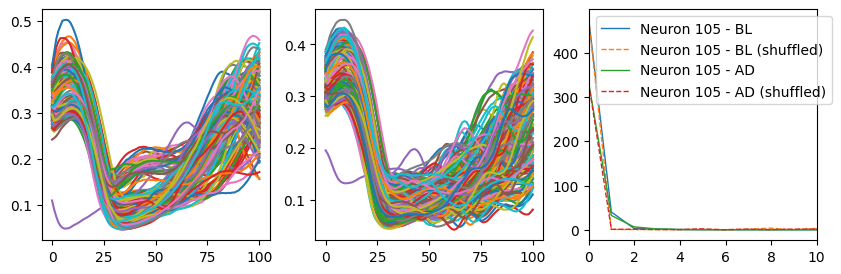

In [20]:
i = 105
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].plot(fr_BL[...,i].T)#,interpolation='none', aspect='auto', cmap=cm.gray)
axes[1].plot(fr[...,i].T) #,interpolation='none', aspect='auto', cmap=cm.gray)

for f in [fr_BL,fr]:
    x = f[:, :, i] # get the AD spike data for neuron i

    xf = fft(x)  # Compute Fourier transform of x
    Sxx_all = (xf * xf.conj()).real  # Compute spectrum

    Sxx = np.mean(Sxx_all, axis=0)  # trial average per epoch

    faxis = fftfreq(len(Sxx)) / dt  # Construct frequency axis

    axes[2].plot(faxis[:len(faxis)//2], Sxx[:len(faxis)//2], linewidth=1,
                 label=f'Neuron {i} - {"BL" if f is fr_BL else "AD"}')
    
    #shuffle
    xf = fft(np.random.permutation(x.T).T)  # Compute Fourier transform of shuffled x
    Sxx_all = (xf * xf.conj()).real  # Compute spectrum

    Sxx = np.mean(Sxx_all, axis=0)  # trial average per epoch

    axes[2].plot(faxis[:len(faxis)//2], Sxx[:len(faxis)//2], linewidth=1, linestyle='--',
                 label=f'Neuron {i} - {"BL" if f is fr_BL else "AD"} (shuffled)')
axes[2].set_xlim(0, 10)
axes[2].legend()

In [ ]:
# # save summary
# with open(f"./results/spiking_{spike_data_dir.split('.mat')[0]}.csv", "w") as f:
#     m1 = pd_data['M1_spikes'][0].shape[1]
#     f.write(f"M1 neurons: {m1}\n")
#     if len(results) > 0:
#         for r in results:
#             f.write(f"{r[0]:.1f} Hz: {int(r[1]):d},\t")
#         f.write("\n")
#         U = np.unique(results[...,1])
#         f.write(f"{np.sum(U<=m1)},\t{np.sum(U>m1)}")
#         f.write("\n")
#         for r in results_weak:
#             f.write(f"{r[0]:.1f} Hz: {int(r[1]):d},\t")
#         f.write("\n")
#         U = np.unique(results_weak[...,1])
#         f.write(f"{np.sum(U<=m1)},\t{np.sum(U>m1)}")

# np.save(f"./results/oscillating_score_{spike_data_dir.split('.mat')[0]}.npy", oscillating_score)


In [9]:
def get_target_ids(true_target_direction):
    ''' substitute direction elements with ids '''
    uniq_dirs = np.unique(true_target_direction)
    true_label = np.array([np.where(uniq_dirs==t)[0][0] for t in true_target_direction])
    return true_label

target_ids = get_target_ids(true_target_direction)

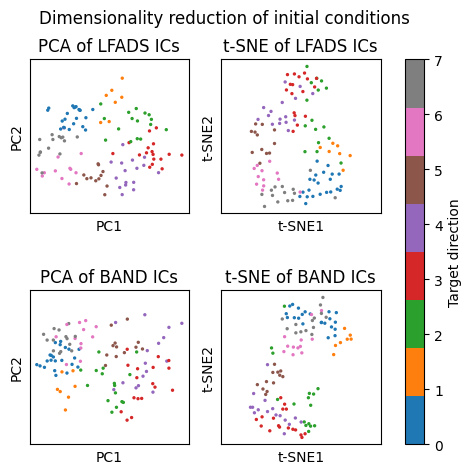

In [12]:
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(2,2,figsize=(5.2,5))
fig.suptitle('Dimensionality reduction of initial conditions')

ccolors = plt.get_cmap(cm.tab10)(np.arange(8, dtype=int))
cmap = ListedColormap(ccolors)

for model_name, model_dest, ic_pca, ic_tsne, ax in zip(['LFADS','BAND'], model_dests, both_pca, both_tsne, axes):
    ax[0].scatter(*ic_pca.T,c=target_ids,s=2,cmap=cmap)
    ax[0].set_title(f'PCA of {model_name} ICs')
    ax[0].set_xlabel('PC1')
    ax[0].set_ylabel('PC2')
    sm = ax[1].scatter(*ic_tsne.T,c=target_ids,s=2,cmap=cmap)
    ax[1].set_title(f't-SNE of {model_name} ICs')
    ax[1].set_xlabel('t-SNE1')
    ax[1].set_ylabel('t-SNE2')


# add colorbar
fig.colorbar(sm, ax=axes[:,1], orientation='vertical',label='Target direction')

for ax in axes.flatten():
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(hspace=0.5,right=0.8)

fig.savefig(f"figs/initial_conditions.pdf")

# TODO: add LDA score
